### Suman Roy(MDS202041), Time Series Analysis Assignment 2

### Importing the Libraries

In [93]:
options(warn=-1)

In [94]:
library(tseries)
library(zoo)
library(rugarch)
library(forecast)


### Importing Apple stock data 

I have taken APPLE stock data(Close Price) from 2017-11-01 to 2021-11-27 as the time series. The last 6 data pints have been segregated later as test data for the evaluation of the forecast. 

In [95]:
start_date <- as.Date("2017-11-01")
end_date <- as.Date("2021-11-27")
stock<-get.hist.quote(instrument = "AAPL",start=start_date,end=end_date,quote="Close",provider = "yahoo") 

time series ends   2021-11-26


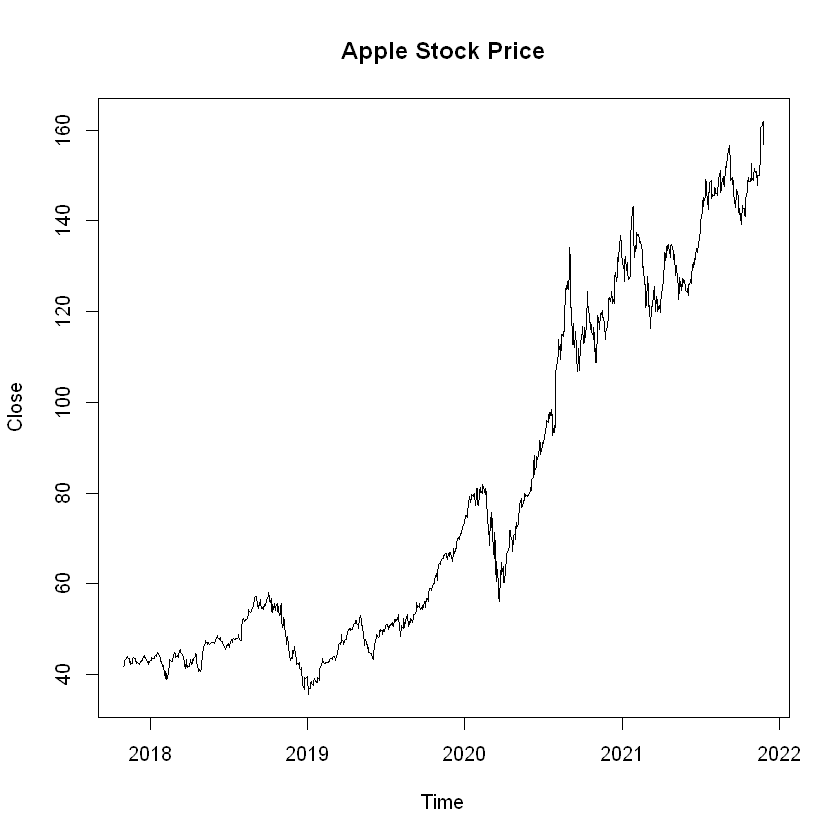

In [81]:
plot(stock, xlab = "Time", ylab ="Close", main = "Apple Stock Price")

### Stationarity checking of the time series 

{Pt}

In [4]:
data = ts(stock)

In [5]:
adf.test(data)


	Augmented Dickey-Fuller Test

data:  data
Dickey-Fuller = -1.9878, Lag order = 10, p-value = 0.5835
alternative hypothesis: stationary


In [96]:
kpss.test(data)


	KPSS Test for Level Stationarity

data:  data
KPSS Level = 11.68, Truncation lag parameter = 7, p-value = 0.01


In [7]:
pp.test(data)


	Phillips-Perron Unit Root Test

data:  data
Dickey-Fuller Z(alpha) = -6.8378, Truncation lag parameter = 7, p-value
= 0.7283
alternative hypothesis: stationary


For ADF and PP test Null hypothesis is : "The time series has a unit root and hence not stationary", and alternative hypothesis is: "The time series is stationary". We see that for both PP and ADF test p-values are 0.7283 and 0.5835 respectively.They are significantly higher than the significance level of 0.05. So we fail to reject the null hypothesis for these two tests. From ADF and PP test the conclusion is the time series is not stationary. Now for KPSS test, the Null Hypothesis is: "The time series is stationary" and the alternative hypohesis is:"The time series has a unit root and hence not stationary." We see that for KPSS test the p-value is 0.01 which is lower than the significance leve of 0.05. So we can reject the null hypothesis. The conclusion from KPSS test also comes out to be that the data is not stationary. 

### Log Retrun Series

Yt = log( Pt/Pt-1)


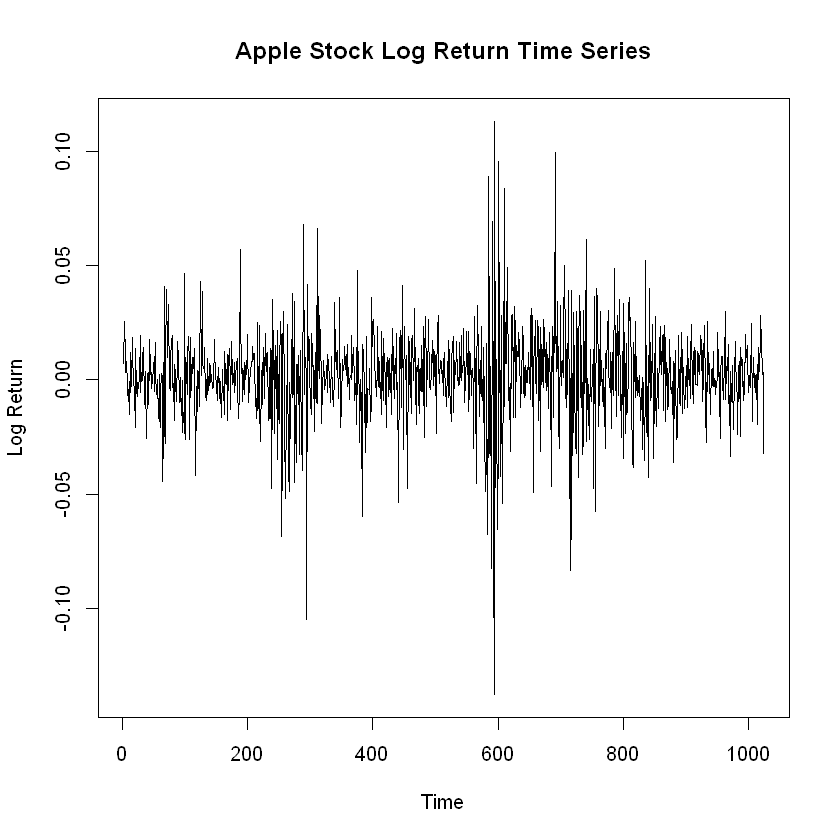

In [82]:
data2 = diff(log(data))
plot(data2, xlab = "Time", ylab = "Log Return",main = "Apple Stock Log Return Time Series")

So after taking the log return we can see that the time series has been stationary(more or less) from the plot. We will now perform the stationarity tests of the log return data. 


### Stationarity checking of Log return series

In [97]:
adf.test(data2)


	Augmented Dickey-Fuller Test

data:  data2
Dickey-Fuller = -9.1362, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


In [98]:
kpss.test(data2)


	KPSS Test for Level Stationarity

data:  data2
KPSS Level = 0.11868, Truncation lag parameter = 7, p-value = 0.1


In [99]:
pp.test(data2)


	Phillips-Perron Unit Root Test

data:  data2
Dickey-Fuller Z(alpha) = -1183.5, Truncation lag parameter = 7, p-value
= 0.01
alternative hypothesis: stationary


For PP test and ADF test p-value is less than 0.05(significance level). So we can reject the null hypothesis. So, the log return series is staionary. Similarly the p-value for KPSS test is 0.1 which is greater than 0.05(significance level). SO we fail to reject null hypothesis. So, from that test also the conclusion is that the log return series is stationary. 

### Train - Test split of the dataset

As mentioned earlier, I have taken last 6 data points as test values. 

In [12]:
period = 6
n<- length(data2)
train_lim = n - period
train_data = data2[c(1:train_lim)]
test_data = data2[c((train_lim+1):n)]

In [13]:
length(train_data)
length(test_data)

[1] 1018

[1] 6

### Fitting ARMA Model (Using AIC and BIC Values)

In [83]:
diff<-ndiffs(train_data)

In [84]:
aic_model = auto.arima(train_data,max.p = 5, max.q = 5,d = diff, ic = "aic")
aic_model

Series: train_data 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      -0.142  0.0013
s.e.   0.031  0.0006

sigma^2 estimated as 0.0004118:  log likelihood=2524.1
AIC=-5042.21   AICc=-5042.18   BIC=-5027.43

In [16]:
bic_model = auto.arima(train_data,max.p = 5, max.q = 5,d =diff, ic = "bic")
bic_model

Series: train_data 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.1376
s.e.   0.0310

sigma^2 estimated as 0.0004136:  log likelihood=2521.49
AIC=-5038.97   AICc=-5038.96   BIC=-5029.12

So from both AIC and BIC selection crietria, ARMA(1,0) seems to be the most suited model.

### Forecast of ARMA(1,0) model

In [85]:
pred_arima<- forecast(aic_model, h = period)
arima_forecast<- pred_arima$mean

### Residuals and Squared residuals of ARMA(1,0) Model

In [86]:
res = aic_model$residuals
res2 = res ^ 2

### Ljung-Box test on residual(res) and squared residual(res2)


In [89]:
Box.test(res, lag = 6, type = c("Ljung-Box"))


	Box-Ljung test

data:  res
X-squared = 2.4392, df = 6, p-value = 0.8752


In [90]:
Box.test(res2,lag = 6, type = c("Ljung-Box"))


	Box-Ljung test

data:  res2
X-squared = 315.28, df = 6, p-value < 2.2e-16


So, we fail to reject the null hypothesis of Ljung-Box test for residuals but we can reject the null hypothesis for squared residuals based on the pavlue. 

### Calculating the order of Garch model using AIC and BIC

In [34]:
aic.garch <- matrix(0,4,4)
bic.garch <- matrix(0,4,4)

for (i in 1:4) {
  for (j in 1:4) {
    garch.spec = ugarchspec(variance.model = list(garchOrder=c(i,j)), 
                            mean.model = list(armaOrder=c(1,0),include.mean = FALSE),
                            distribution.model = "std")
    garch.fit = ugarchfit(spec=garch.spec, data=train_data,
                          solver.control=list(trace = 1))
    aic.garch[i,j] <- infocriteria(garch.fit)[1]
    bic.garch[i,j] <- infocriteria(garch.fit)[2]
  }
}


Iter: 1 fn: -2687.8018	 Pars:  -0.03378778  0.00001653  0.13438727  0.83079303  5.01633288
Iter: 2 fn: -2687.8018	 Pars:  -0.03377634  0.00001653  0.13438606  0.83080264  5.01598904
solnp--> Completed in 2 iterations

Iter: 1 fn: -2687.6933	 Pars:  -0.034068471  0.000016649  0.135032577  0.830126386  0.000003985  4.996593500
Iter: 2 fn: -2687.6933	 Pars:  -0.03406801  0.00001665  0.13502674  0.83013200  0.00000197  4.99681487
solnp--> Completed in 2 iterations

Iter: 1 fn: -2687.8643	 Pars:  -0.0341752376  0.0000166116  0.1358300109  0.8300078220  0.0000012835  0.0000009903  4.9875395171
Iter: 2 fn: -2687.8643	 Pars:  -0.0341745279  0.0000166119  0.1358323715  0.8300078473  0.0000006433  0.0000006955  4.9874129379
solnp--> Completed in 2 iterations

Iter: 1 fn: -2687.6818	 Pars:  -0.0347195925  0.0000166276  0.1358544537  0.8302050625  0.0000004293  0.0000005931  0.0000004559  4.9671774233
Iter: 2 fn: -2687.6818	 Pars:  -0.0347910918  0.0000166438  0.1359185087  0.8300978178  0.000000

In [35]:
which(aic.garch == min(aic.garch), arr.ind = TRUE)

row,col
1,1


In [36]:
which(bic.garch == min(bic.garch), arr.ind = TRUE)

row,col
1,1


GARCH(1,1) seems to be the best suited model(from both AIC and BIC). Here we have stored the AIC and BIC values of differentc orders of GARCH models like (1,1),(1,2),(2,1)...(4,4) into two 4X4 matrices and took the order producing minimum AIC and BIC value respectively. For both AIC and BIC GARCH(1,1) is the best model. 

### Fitting the appropriate GARCH Model

In [33]:
parm = ugarchspec(variance.model = list(model = "sGARCH", 
                                        garchOrder = c(1,1)),
                  mean.model     = list(armaOrder = c(1,0)),
                  distribution.model = 'norm' )
garch <- ugarchfit(spec = parm , data = train_data)
garch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002185    0.000475   4.5983 0.000004
ar1    -0.039600    0.035350  -1.1202 0.262620
omega   0.000016    0.000004   3.9601 0.000075
alpha1  0.157138    0.027116   5.7950 0.000000
beta1   0.808121    0.023297  34.6873 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002185    0.000498   4.3826 0.000012
ar1    -0.039600    0.033927  -1.1672 0.243126
omega   0.000016    0.000006   2.5327 0.011320
alpha1  0.157138    0.039698   3.9583 0.000075
beta1   0.808121    0.026304  30.7222 0.000000

LogLikelihood : 2663.794 

Information Criteria
------------------------------------
                

### Forecasting from GARCH model

In [48]:
pred_garch = ugarchforecast(garch, data = train_data, n.ahead = period)

garch_forecast<- pred_garch@forecast$seriesFor

## Plotting

### Plotting of Forecast and Test values of log return of Stock Price 

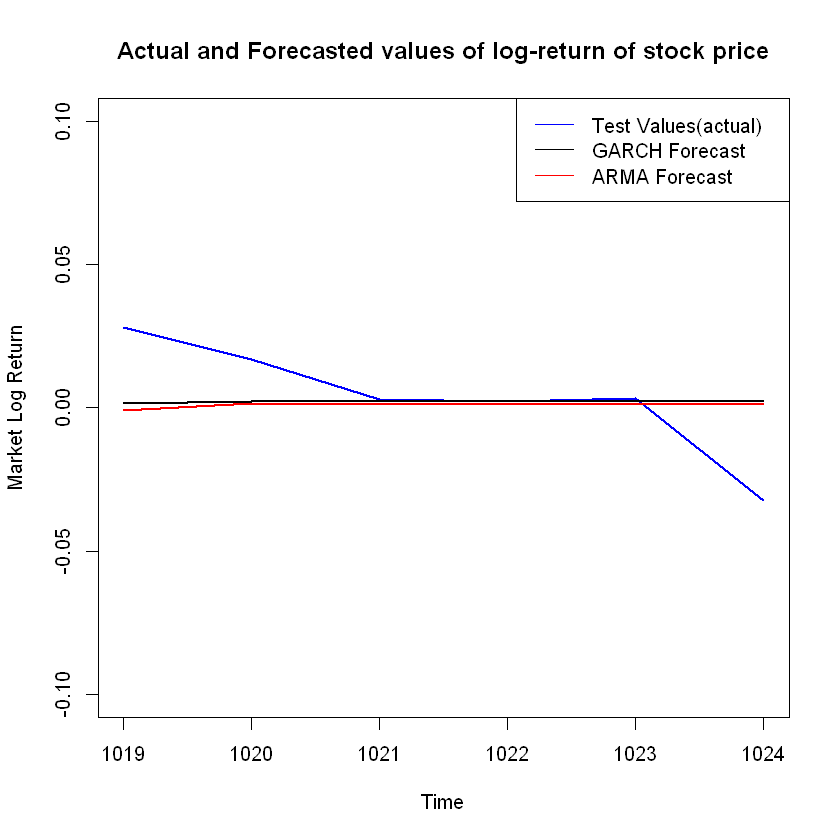

In [74]:
plot(NULL,xlim = c((train_lim+1),n),ylim = c(-0.1,0.1),ylab = 'Market Log Return',xlab='Time',
     main = 'Actual and Forecasted values of log-return of stock price')
points(c((train_lim+1):n), test_data,type='l',lwd=2,col='blue')
points(c((train_lim+1):n), arima_forecast, type='l', lwd = 2, col = 'red')
points(c((train_lim+1):n), garch_forecast,type='l',lwd=2,col='black')
legend("topright",legend =  c("Test Values(actual)","GARCH Forecast","ARMA Forecast"),
       col = c("blue","black","red"),lty = 1)

But this forecast is the log return of stock price(log(Pt/Pt-1)). We have to convert it to actual stock price(Pt) to get the price forecast of the stock.

### Conversion of the forecast of log return of the stock prices into stock prices

In [62]:
pred_arma_d1 = ts(c(train_data, arima_forecast))
pred_garch_d1 = ts(c(train_data, garch_forecast))

pred_arma = ts(exp(cumsum(c((log(data))[1],pred_arma_d1))), start = c(2017,11,1), frequency = 365 )
pred_garch = ts(exp(cumsum(c((log(data))[1],pred_garch_d1))), start = c(2017,11,1), frequency = 365)

### Plotting of Forecast and Test values of Actual Stock Price 

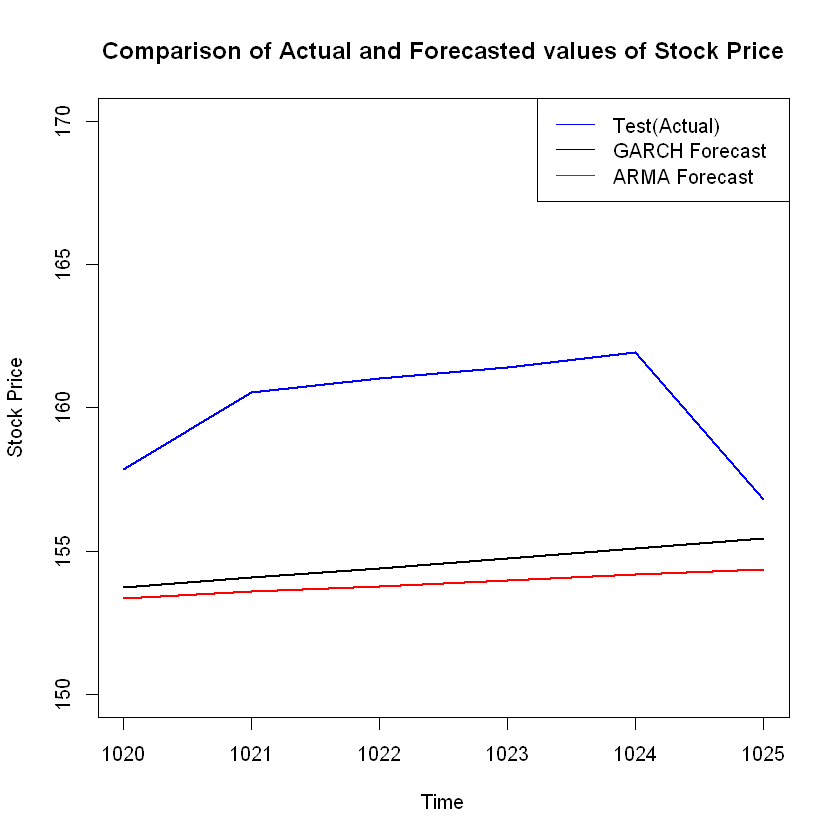

In [92]:
plot(NULL,ylab = 'Stock Price',xlab='Time',xlim=c(1020,1025),ylim = c(150,170),
     main = 'Comparison of Actual and Forecasted values of Stock Price')

points(c((length(data)-period+1):length(data)),data[(length(data)-period+1):length(data)],type='l',lwd=2,col='blue')
points(c((length(data)-period+1):length(data)), pred_arma[(length(data)-period+1):length(data)], type='l', lwd = 2, col = 'red')
points(c((length(data)-period+1):length(data)), pred_garch[(length(data)-period+1):length(data)],type='l',lwd=2,col='black')
legend("topright",legend =  c("Test(Actual)","GARCH Forecast", "ARMA Forecast"),col = c("blue","black", "red"),lty = 1)

## Calculation of Mean Squared Error

### Considering the Log return of stock prices

MSE for ARMA

In [76]:
mse_arma=sum((test_data-arima_forecast)^2)/period
mse_arma

[1] 0.0003669844

MSE for GARCH

In [77]:
mse_garch = sum((test_data - forecast_garch)^2)/period
mse_garch

[1] 0.0003500604

### Considering actual stock prices

MSE for ARMA

In [79]:
mse_arma_actual=sum((data[(length(data)-period+1):length(data)]-pred_arma[(length(data)-period+1):length(data)])^2)/period
mse_arma_actual

[1] 40.34746

MSE for GARCH

In [80]:
mse_garch_actual=sum((data[(length(data)-period+1):length(data)]-pred_garch[(length(data)-period+1):length(data)])^2)/period
mse_garch_actual

[1] 32.60887

So, Mean Squared Error of GARCH Model is lower than that of ARMA Model. 